In [85]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
!cat flowanalysis.m

close all
clear all

load NACA0012_flowfieldv2.dat

imax = 513;
jmax = 257;
TE_start = 65; % Trailing Edge Lower Point
TE_end = 449; % Trailing Edge Upper Point
LE = 257; % Leading Edge Point
gamma = 1.4;
mach = 0.1;
p0 = 1.; % Freestream static pressure
alpha = 8; % Angle of Attack
Re = 3e6; % Reynolds number



k = 1;
for j=1:jmax
    for i=1:imax
        x(i,j) = NACA0012_flowfieldv2(k,1);
        y(i,j) = NACA0012_flowfieldv2(k,2);
        k = k +1;
    end
end



% Plot the Airfoil Surface
figure(1)
hold on
plot(x(TE_start:TE_end,1),...
    y(TE_start:TE_end,1),'k*-')
plot(x(1:imax,1),...
    y(1:imax,1),'g.')
axis equal
axis([-.1 1.1 -.2 .2])

% 
% %Plot the Computational Domain.
% figure(2)
% axis equal
% hold on
% for j=1:jmax
%     plot(x(1:imax,j),y(1:imax,j),'k-')  
% end
% for i=1:imax
%     plot(x(i,1:jmax),y(i,1:jmax),'k-')
% end


%Plot the Computational Domain.
figure(3)
axis equal
hold on
for j=1:1
    plot(x(1:imax,j),y(1:imax,j),'k-')  
end
%for i=1:imax
%    plot(x(

In [5]:
imax = 513
jmax = 257
TE_start = 65 - 1  # Trailing Edge Lower Point
TE_end = 449 - 1    # Trailing Edge Upper Point
LE = 257 - 1       # Leading Edge Point
gamma = 1.4
mach = 0.1
p0 = 1.0  # Freestream static pressure
alpha = 8.0  # Angle of Attack
Re = 3e6  # Reynolds number

In [6]:
variables = ['X', 'Y', 'RHO', 'RHO-U', 'RHO-V', 'RHO-E', 'MU', 'WHAT', 'D2WALL']
variables = ['"%s"'%v for v in variables]
with open('tecdata.dat', 'w') as f:
    f.write(' TITLE = "PROJECT 5"\n')
    f.write(' FILETYPE = FULL\n')
    f.write(' VARIABLES = %s\n' % ' '.join(variables))
    f.write(' ZONE\n')
    f.write(' I = %i, J = %i, F=POINT\n' % (imax, jmax))
    f.write(open('NACA0012_flowfieldv2.dat').read())

In [7]:
dat = np.genfromtxt('NACA0012_flowfieldv2.dat', unpack=True)

In [8]:
def unpack(cols):
    r = []
    for col in cols:
        r.append(col.reshape((jmax, imax)).T)
    return r

In [126]:
x, y = unpack(dat[0:2,:])
w = np.empty((4, imax, jmax))
w[:] = unpack(dat[2:6])
rlv, rev, d2wall = unpack(dat[6:])
u = w[1]/w[0]
v = w[2]/w[0]
UV = np.array([u, v])
pressure = (gamma - 1)*( w[3] - 0.5*(w[1]**2 + w[2]**2)/w[0] )
U = np.sqrt(u**2 + v**2)

In [61]:
airfoil = np.s_[TE_start:TE_end+1]
_w = lambda s: np.index_exp[s,0]
wall = _w(airfoil)
lower = _w(np.s_[TE_start:LE+1])
upper = _w(np.s_[LE:TE_end+1])

In [120]:
# Compute surface values
num_airfoil_nodes = TE_end - TE_start + 1
normals = np.empty((num_airfoil_nodes - 1, 2))
areas = np.empty(num_airfoil_nodes - 1)
xc = np.empty_like(areas)
yc = np.empty_like(areas)
x_wall = x[wall]
y_wall = y[wall]
assert num_airfoil_nodes == len(x_wall)
for i in range(num_airfoil_nodes - 1):
    xc[i] = 0.5*(x_wall[i+1] + x_wall[i])
    yc[i] = 0.5*(y_wall[i+1] + y_wall[i])
    dx = x_wall[i+1] - x_wall[i]
    dy = y_wall[i+1] - y_wall[i]
    l = np.sqrt(dy**2 + dx**2)
    normals[i] = np.array([-dy, dx])/l
    areas[i] = l  # Assume span = 1

In [130]:
# Compute nodal stress tensor on wall
# gradUV = np.empty((num_airfoil_nodes, 2, 2))
gradUV = np.empty((2, 2))
tau_na = np.empty((num_airfoil_nodes, 2))  # tau_n and tau_a
for n in range(1, num_airfoil_nodes - 1):
    gn = wall2global[n]
    dxdi = 0.5*(x[gn+1,0] - x[gn-1,0])
    dxdj = x[gn,1] - x[gn,0]
    dydi = 0.5*(y[gn+1,0] - y[gn-1,0])
    dydj = y[gn,1] - y[gn,0]
    J = dxdi*dydj - dxdj*dydi
    didx = J*dydj
    djdx = -J*dydi
    didy = -J*dxdj
    djdy = J*dxdi
    for k in range(2):
        dUVdi = 0.5*(UV[k,gn+1,0] - UV[k,gn-1,0])
        dUVdj = UV[k,gn,1] - UV[k,gn,0]
        gradUV[k,0] = dUVdi*didx + dUVdj*djdx
        gradUV[k,1] = dUVdi*didy + dUVdj*djdy
    
    mu = rlv[gn,0]
    term = (-2.0/3.0)*mu*(gradUV[0,0] + gradUV[1,1])
    tauxx = 2*mu*gradUV[0,0] + term
    tauyy = 2*mu*gradUV[1,1] + term
    tauxy = mu*(gradUV[0,1] + gradUV[1,0])
    nx, ny = 0.5*(normals[n-1] + normals[n])
    tau_na[n,0] = nx*tauxy + ny*tauyy
    tau_na[n,1] = nx*tauxx + ny*tauxy

In [63]:
# Compute tau wall
def project(a, b):
    '''Project vector a onto b.
    
    b is of unit length.'''
    return a.dot(b)*b



In [100]:
# def draw_vector(ax, x, y, vec, scf=0.001, width=1e-5, **kwargs):
#     mag = np.linalg.norm(vec)
#     if mag == 0:
#         return
#     unit_vec = vec/mag
#     ax.arrow(x, y, scf*vec[0], scf*vec[1], width=width, **kwargs)

def draw_vector(ax, x, y, vec, scf=0.001, *args, **kwargs):
    p0 = np.array([x, y])
    p1 = np.array([x, y]) + scf*vec
    ax.plot([p0[0], p1[0]], [p0[1], p1[1]], *args, **kwargs)

In [119]:
# wall2global = np.arange(airfoil.start, airfoil.stop + 1, 1)
# tauw = np.zeros_like(x_wall)
# cf = np.zeros_like(tauw)
# # Loop over nodes excluding the first and last (at TE singularity)
# for n in range(1, num_airfoil_nodes - 1):
#     gn = wall2global[n]
#     normal = 0.5*(normals[n-1] + normals[n])
#     uw = np.array([u[gn, 0], v[gn, 0]])
#     uwt = uw - project(uw, normal)
#     up1 = np.array([u[gn, 1], v[gn, 1]])
#     up1t = up1 - project(up1, normal)
# #     draw_vector(ax, x_wall[n], y_wall[n], up1, 0.1, 'b-o')
# #     draw_vector(ax, x_wall[n], y_wall[n], up1t, 0.1, 'r-o')
# #     diff = (up1t - up1)/up1
#     dn = np.sqrt((x[gn,1] - x[gn,0])**2 + (y[gn,1] - y[gn,0])**2)
#     dudn = (np.linalg.norm(up1t) - np.linalg.norm(uwt))/dn
#     tauw[n] = rlv[gn]*dudn
#     cf[n] = tauw[n]/(0.5*)

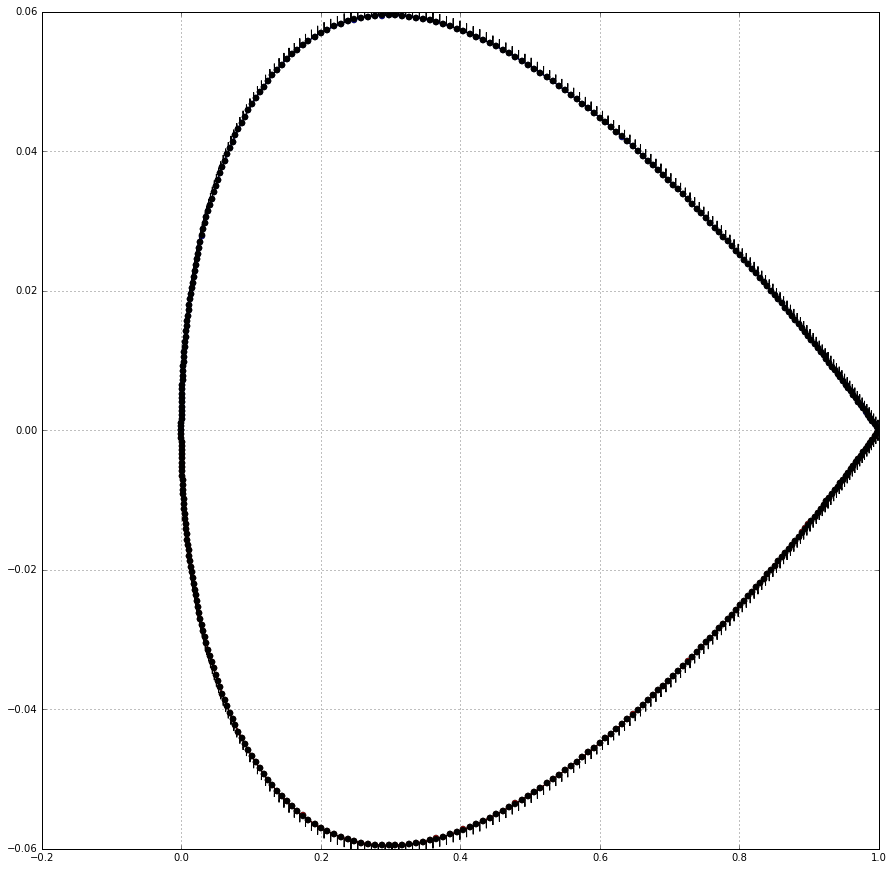

In [80]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(x[lower], y[lower], 'r-o')
ax.plot(x[upper], y[upper], 'b-o')
ax.plot(xp1, yp1, 'k-o')
# ax.set_xlim(-0.01, 0.01)
# ax.set_xlim(0.99, 1.01)
# ax.set_ylim(-0.01, 0.01)
for i in range(len(xc)):
    ax.arrow(xc[i], yc[i], 0.001*normals[i,0], 0.001*normals[i,1], width=1e-5)

ax.grid()